<a href="https://colab.research.google.com/github/AntraSinha/Deep-Learning/blob/main/MIS285N_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIS 285N Homework 3
**Due: Thursday, February 15, 11:59 pm**

Submit:

A pdf of your notebook with solutions.
A link to your colab notebook or also upload your .ipynb if not working on colab.

# Goals of this Homework: Fine Tuning and Transfer Learning

The goal of this colab notebook and homework is to get down the basics of Transfer learning, and harnessing the power of pre-trained notebooks. Along the way, we get experience with creating and labeling data sets, and a number of other Python tools.

Specifically, we do the following:

* In this colab notebook, we create our own labeled image data set, with calls to the Bing API. We use this to download images with user-specified labels, into train and test directories.

* We preprocess all the images and use the directory names as lables to create our training and testing data sets.

* Then we download a pre-trained convolutional neural network from Pytorch. There is wide selection here. These have been trained on ImageNet. See references below.

* Then we add a new last layer, and train. Note that the last layer we add has to have the right size, namely, the number of classes in our data.

* Things to play with: Choosing different pre-trained models; Fine tuning the entire network vs freezing and fine tuning only the last layer or layers; Possibly adding more of our own layers at the end. (See the last optional problem at the end).


Some references:

The bing image downloader package from here https://pypi.org/project/bing-image-downloader/


# The following will allow us to call the Bing Image Downloader

In [ ]:
!pip install bing-image-downloader


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import requests
from bing_image_downloader import downloader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

plt.ion()   # interactive mode


# Downloading the images we need

In [ ]:
# These are the functions we need for asking for query terms, number of images
# and the fraction of train/test split
def get_query_terms():
    """Ask the user for a list of query terms."""
    queries = input("Enter query terms separated by commas: ").split(',')
    return [query.strip() for query in queries]


def get_positive_integers():
    """Ask the user for a list of positive integers."""
    while True:
        numbers = input("Enter positive integers corresponding to each query, separated by commas: ").split(',')
        try:
            # Convert string inputs to integers
            numbers = [int(num.strip()) for num in numbers]

            # Check if all numbers are positive
            if all(num > 0 for num in numbers):
                return numbers
            else:
                print("All numbers must be positive. Please try again.")
        except ValueError:
            print("Invalid input. Please enter integers only.")


def get_train_test_proportion():
    """Ask the user for a number between 0 and 1 and ensure it is in that range."""
    while True:
        try:
            # Ask the user for a number and try to convert it to a float
            num = float(input("What fraction of the data should be training? For example, enter 0.75 for 75 percent: "))

            # Check if the number is between 0 and 1 (inclusive)
            if 0 <= num <= 1:
                return num
            else:
                print("The number must be between 0 and 1. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a valid number between 0 and 1.")

# Problem 0

Run the above code, to make your own data set. Choose terms that aren't already one of the 1000 classes in the Imagenet dataset.

I recommend starting small: 2 or 3 different terms, and maybe 100-200 images max from each.

In [ ]:
# Now we get the queries
queries = get_query_terms()
# And the number of each
numbers = get_positive_integers()
# And the fraction of training data
frac_train = get_train_test_proportion()
# Check if number of queries matches number of positive integers
if len(queries) != len(numbers):
  print("Number of queries and integers do not match!")

for query, n in zip(queries, numbers):
  n_tr = int(math.floor(n*frac_train))
  downloader.download(query, limit=n_tr, output_dir='dataset/train', adult_filter_off=True, force_replace=False,timeout=60, verbose=False)
  n_test = int(math.floor(n * (1-frac_train)))
  downloader.download(query, limit=n_test, output_dir='dataset/test', adult_filter_off=True, force_replace=False, timeout=60, verbose=False)


Enter query terms separated by commas: fork,finger,rat
Enter positive integers corresponding to each query, separated by commas: 100,100,100
What fraction of the data should be training? For example, enter 0.75 for 75 percent: 0.8
[%] Downloading Images to /content/dataset/train/fork
[!] Issue getting: https://i.redd.it/w4bjd02rkud41.jpg
[!] Error:: HTTP Error 403: Blocked
[!] Issue getting: http://gricefostereventhire.co.uk/wp-content/uploads/2015/06/fork.jpg
[!] Error:: HTTP Error 404: Not Found
[!] Issue getting: http://all4desktop.com/data_images/original/4244685-fork.jpg
[!] Error:: HTTP Error 404: Not Found
[!] Issue getting: https://weknowyourdreams.com/images/fork/fork-05.jpg
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)>
[!] Issue getting: http://all4desktop.com/data_images/original/4244680-fork.jpg
[!] Error:: HTTP Error 404: Not Found
[Error]Invalid image, not saving https://bike.bi

# Let's make sure we downloaded enough of each

In [ ]:
import os

def count_files_in_directory(directory, prefix=""):
    """
    Recursively counts the number of files in each directory and subdirectory.

    Args:
    - directory: The directory path to start counting from.
    - prefix: A string used for indentation to visualize the folder structure.
    """
    num_files = sum([len(files) for r, d, files in os.walk(directory)])
    print(f"{prefix}{os.path.basename(directory)}: {num_files} files")

    for subdir in next(os.walk(directory))[1]:  # List subdirectories of the current directory
        path = os.path.join(directory, subdir)  # Full path of the subdirectory
        count_files_in_directory(path, prefix + "  ")  # Recursively count in this subdirectory

# Path to the dataset directory
dataset_dir = './dataset'

# Start the recursive count
count_files_in_directory(dataset_dir)


dataset: 297 files
  train: 240 files
    finger: 80 files
    rat: 80 files
    fork: 80 files
  test: 57 files
    finger: 19 files
    rat: 19 files
    fork: 19 files


# Preprocessing the data

Now that we've downloaded the data we want, we do some basic preprocessing with functions from Torchvision.

For the training data, we normalize and also use some data augmentation.

For the validation set, we just normalize.

# Problem 1 (Nothing to turn in)
Read about this here: https://pytorch.org/vision/stable/transforms.html

# We made dataloaders out of our training and testing data

In [ ]:

# Data augmentation and normalization for training
# Just normalization for validation

# The directory that contains the data
data_dir = 'dataset'

# Now we apply the usual transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class_names

['finger', 'fork', 'rat']

# Problem 2
Write code that calls the dataloaders and displays some number of images, with their true labels.

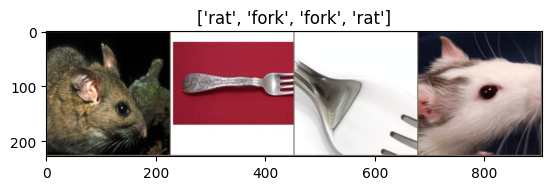

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
plt.show()

# Download a pre-trained model

We will now download a pretrained model that has been trained on Imagenet. I recomend starting with Resnet18. See here for other larger or smaller pre-trained modfels https://pytorch.org/vision/stable/models.html

In [ ]:
# Now we load a pre-trained model, and replace the last layer with a non-initialized linear layer.

# This command loads a pre-trained model
model_ft = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


# Problem 3

Redefine the last layer of your neural network (called model_ft) to be a linear (fully connected layer) whose input size is whatever the input size is of the the current last layer, and whose output size is the number of labels your new data set has.

You need to figure out how to do this. It's not too difficult. You need will use similar commands as you used in the last 2 homeworks in order to define a linear layer. The key will be to find out what the last layer is called, and also to find out what is its input size, so that you can properly define the size of the last fully connected (linear) layer.

In [ ]:
import torch.nn as nn

# Assuming model_ft is already loaded with pre-trained weights
# Get the input size of the last layer
last_layer_input_size = model_ft.fc.in_features

# Define the output size for your new dataset
num_classes = len(class_names)

# Redefine the last layer to have the appropriate input and output size
model_ft.fc = nn.Linear(last_layer_input_size, num_classes)

model_ft = model_ft.to(device)

# Print the modified model to confirm the changes
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Training

* We are going to fine-tune by training all the layers.

* We can also freeze the old layers, and only update the last layers that we added. (This is not implemented below.)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step() # updates the learning rate

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Parameters of the optimization

# Problem 4 (Optional)
Explore choosing different learning rates or optimizers to see how things go.

In [ ]:
# We need to set the loss function, the optimizer, and the learning rate scheduler
criterion = nn.CrossEntropyLoss()
# though we're fine tuning, we're updating all parameters
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# the scheduler decreases the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train

In [ ]:
# Now we train
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.6706 Acc: 0.6835
test Loss: 0.0152 Acc: 1.0000

Epoch 1/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4749 Acc: 0.8270
test Loss: 0.0101 Acc: 1.0000

Epoch 2/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4186 Acc: 0.8565
test Loss: 0.0097 Acc: 1.0000

Epoch 3/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7376 Acc: 0.7764
test Loss: 0.1085 Acc: 0.9636

Epoch 4/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4764 Acc: 0.8439
test Loss: 0.0390 Acc: 0.9818

Epoch 5/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.5043 Acc: 0.8312
test Loss: 0.0730 Acc: 0.9636

Epoch 6/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.6049 Acc: 0.7764
test Loss: 0.0650 Acc: 0.9636

Epoch 7/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3250 Acc: 0.8776
test Loss: 0.0110 Acc: 1.0000

Epoch 8/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2867 Acc: 0.8945
test Loss: 0.0354 Acc: 0.9818

Epoch 9/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2686 Acc: 0.9156
test Loss: 0.0093 Acc: 1.0000

Epoch 10/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4023 Acc: 0.8439
test Loss: 0.0040 Acc: 1.0000

Epoch 11/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3381 Acc: 0.8608
test Loss: 0.0070 Acc: 1.0000

Epoch 12/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2891 Acc: 0.8692
test Loss: 0.0042 Acc: 1.0000

Epoch 13/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1941 Acc: 0.9156
test Loss: 0.0048 Acc: 1.0000

Epoch 14/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2861 Acc: 0.9030
test Loss: 0.0081 Acc: 1.0000

Epoch 15/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2258 Acc: 0.9325
test Loss: 0.0091 Acc: 1.0000

Epoch 16/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2897 Acc: 0.9030
test Loss: 0.0060 Acc: 1.0000

Epoch 17/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2693 Acc: 0.8903
test Loss: 0.0049 Acc: 1.0000

Epoch 18/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1998 Acc: 0.9072
test Loss: 0.0047 Acc: 1.0000

Epoch 19/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2483 Acc: 0.8987
test Loss: 0.0048 Acc: 1.0000

Epoch 20/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2896 Acc: 0.8903
test Loss: 0.0074 Acc: 1.0000

Epoch 21/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2844 Acc: 0.8861
test Loss: 0.0039 Acc: 1.0000

Epoch 22/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2077 Acc: 0.9367
test Loss: 0.0037 Acc: 1.0000

Epoch 23/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2061 Acc: 0.9325
test Loss: 0.0038 Acc: 1.0000

Epoch 24/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2598 Acc: 0.9156
test Loss: 0.0029 Acc: 1.0000

Training complete in 3m 3s
Best test Acc: 1.000000


# Problem 5

Report your accuracy on the testing set. You should compute this explicitly by running all your testing examples through the model and checking them against their true labels.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 100 %


# Now let's visualize to see how well we did

# Problem 6

Print out images from the test set, reporting the predicted labels and the true labels.

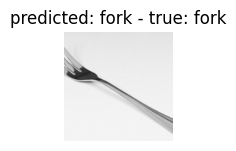

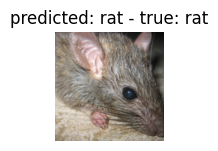

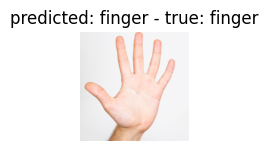

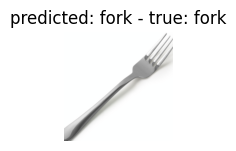

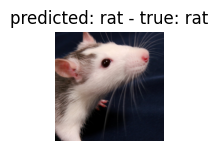

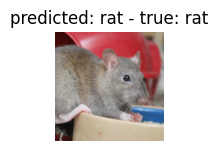

In [ ]:
# Function to display images from the test set along with predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} - true: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)
plt.show()

# Problem 7 (Optional)

Experiment with some/all of the following:

* Play with different pre-trained models
* Experiment with different pre-processing of the data (e.g., turn data augmentation on or off).
* Experiment with adding more/fewer layers, and/or layers of different size.
* Fine tune by training everything or only the last (new) layer -- this requires figuring out how to only update some of the layers.
* Try to reduce the number of images you use for training. How few can you use and still get good accuracy? Remember that you were all able to learn what a Goblin shark is with only one single example.

In [ ]:
# 1. Play with different pre-trained models
# Load a different pre-trained model, for example, ResNet50
model_ft = models.resnet50(pretrained=True)

# Replace the last layer
model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)

In [ ]:
# 2. Experiment with different pre-processing of the data
# Change data augmentation for the training set
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# 3. Experiment with adding more/fewer layers, and/or layers of different size
# Add more layers after the pre-trained backbone
model_ft.fc = nn.Sequential(
    nn.Linear(model_ft.fc.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

In [ ]:
# Set all parameters of the model to require gradients
for param in model_ft.parameters():
    param.requires_grad = True

# Alternatively, you can selectively choose which parameters to require gradients
# For example, if you only want to train the last layer:
for name, param in model_ft.named_parameters():
    if name.startswith('fc'):  # Assuming the last layer is named 'fc'
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
# Define the optimizer to update only the parameters of the last layer
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

model_ft = model_ft.to(device)

# Train the model with only the last layer being trained
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.9998 Acc: 0.4810
test Loss: 0.6451 Acc: 0.9091

Epoch 1/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7678 Acc: 0.6751
test Loss: 0.3039 Acc: 1.0000

Epoch 2/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.5972 Acc: 0.7848
test Loss: 0.1238 Acc: 1.0000

Epoch 3/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.5527 Acc: 0.7890
test Loss: 0.1078 Acc: 1.0000

Epoch 4/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.6060 Acc: 0.7257
test Loss: 0.0904 Acc: 1.0000

Epoch 5/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.5136 Acc: 0.8101
test Loss: 0.0748 Acc: 1.0000

Epoch 6/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4784 Acc: 0.8186
test Loss: 0.0672 Acc: 1.0000

Epoch 7/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4876 Acc: 0.7890
test Loss: 0.0340 Acc: 1.0000

Epoch 8/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4347 Acc: 0.8186
test Loss: 0.0175 Acc: 1.0000

Epoch 9/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4492 Acc: 0.8312
test Loss: 0.0295 Acc: 1.0000

Epoch 10/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4490 Acc: 0.7932
test Loss: 0.0398 Acc: 1.0000

Epoch 11/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4161 Acc: 0.8354
test Loss: 0.0191 Acc: 1.0000

Epoch 12/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4190 Acc: 0.8354
test Loss: 0.0118 Acc: 1.0000

Epoch 13/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3243 Acc: 0.8776
test Loss: 0.0094 Acc: 1.0000

Epoch 14/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4349 Acc: 0.7975
test Loss: 0.0124 Acc: 1.0000

Epoch 15/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.5736 Acc: 0.7722
test Loss: 0.0371 Acc: 1.0000

Epoch 16/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3777 Acc: 0.8481
test Loss: 0.0149 Acc: 1.0000

Epoch 17/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2936 Acc: 0.8734
test Loss: 0.0067 Acc: 1.0000

Epoch 18/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4239 Acc: 0.8608
test Loss: 0.0251 Acc: 1.0000

Epoch 19/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4216 Acc: 0.8481
test Loss: 0.0095 Acc: 1.0000

Epoch 20/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3833 Acc: 0.8523
test Loss: 0.0242 Acc: 1.0000

Epoch 21/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4923 Acc: 0.8143
test Loss: 0.0153 Acc: 1.0000

Epoch 22/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3793 Acc: 0.8650
test Loss: 0.0102 Acc: 1.0000

Epoch 23/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4398 Acc: 0.8397
test Loss: 0.0138 Acc: 1.0000

Epoch 24/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4219 Acc: 0.8059
test Loss: 0.0117 Acc: 1.0000

Training complete in 3m 6s
Best test Acc: 1.000000
